# Libs and pre-definitions

In [1]:
import os
REPOSITORY_PATH = r'/home/luis-felipe/UncEst'
DATA_PATH = os.path.join(REPOSITORY_PATH,'data')
#CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = os.path.join(REPOSITORY_PATH,'torch_models')
PATH_TRAINER = os.path.join(PATH_MODELS,'trainer')

PATH_FIGS = os.path.join(REPOSITORY_PATH,'figs')

### Bibliotecas padrões python e utils pytorch

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from collections import defaultdict

In [4]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [5]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import torch_data
import random


In [40]:
import uncertainty.metrics as metrics

# Analysis

## Definitions

In [7]:
MODEL_ARC = 'VGG_16'
DATA = 'Cifar100'
NAME = MODEL_ARC +'_' + DATA 

data = torch_data.__dict__[DATA](data_dir = DATA_PATH)
model_class = models.__dict__[MODEL_ARC]

weights_path = os.path.join(PATH_MODELS,MODEL_ARC,DATA)
WEIGTH_FILE = 0

Files already downloaded and verified
Files already downloaded and verified


## Upload Models

In [ ]:
def weights_files(weights_path):
    #Get all weight files in weights_path
    files = [f for f in os.listdir(weights_path) if os.path.isfile(os.path.join(weights_path, f)) and f.endswith(".pt")]
    files = sorted(files)
    return files

def upload_weights(file, weights_path):
    files = weights_files(weights_path)

    if isinstance(file,int):
        weights = files[file]
        weights = os.path.join(weights_path,weights)
    elif file == 'random':
        weights = random.choice(files)
        weights = os.path.join(weights_path,weights)
    elif file == 'max':
        return upload_weights(0, weights_path)
    elif isinstance(file,str):
        if file in files:
            weights = os.path.join(weights_path,file)
        elif file+'.pt' in files:
            weights = os.path.join(weights_path,file+'.pt')
        else: raise Exception("No file named ", file)
    state_dict = torch.load(weights)
    return state_dict


In [ ]:
model = model_class(num_classes = data.n_classes, name = NAME).to(dev)
model.load_state_dict(upload_weights(WEIGTH_FILE ,weights_path))
model.eval()
acc_model = TE.model_acc(model,data.test_dataloader)
rk_model = 1-0.01*acc_model
print(f'Acurácia = {acc_model}')

## Plots

### Deterministic

In [11]:
name = NAME + '_Deterministic'
model.eval()

In [ ]:
RC = metrics.selective_metrics(model,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05), name = name)

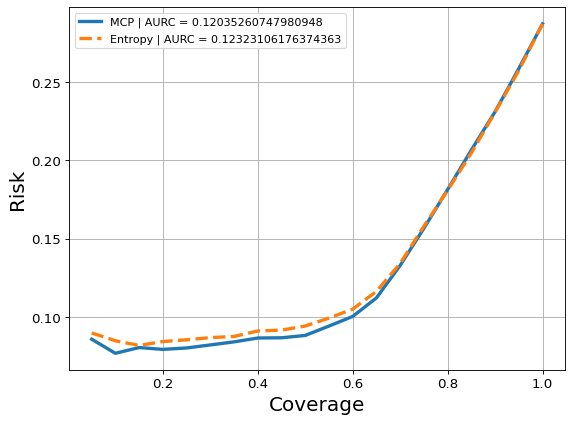

In [12]:
RC.plot_RC(aurc = True)
#plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

### Deep Ensemble

In [ ]:
from uncertainty.ensemble import DeepEnsemble

##### Upload models

In [ ]:
models_dict = defaultdict() #dict to store models
for s in weights_files(weights_path):
    print(s)
    models_dict[s.replace('.pt','')] = model_class(num_classes = data.n_classes).to(dev)
    state_dict = torch.load(os.path.join(weights_path,s))
    models_dict[s.replace('.pt','')].load_state_dict(state_dict)
    models_dict[s.replace('.pt','')].eval()
    models_dict[s.replace('.pt','')].softmax = True


In [14]:
name = NAME + '_DeepEnsemble'

model_ens = DeepEnsemble(models_dict,name=name).to(dev)
print(f'Ensemble Total Accuracy: {TE.model_acc(model,data.test_dataloader)}')

Ensemble Total Accuracy: 74.98


##### Analysis

In [ ]:
RC = metrics.selective_metrics(model_ens,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.fix_plot_scale(y_range=(0,rk_model))

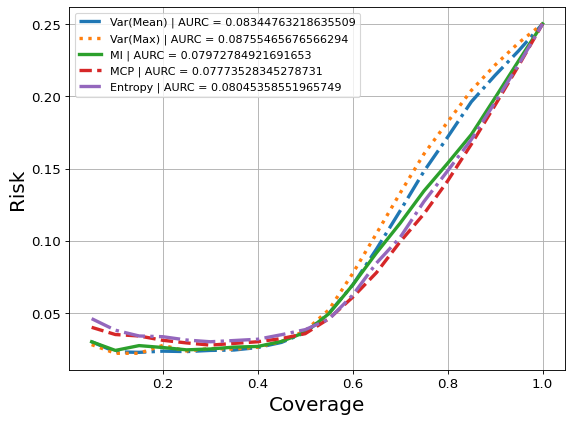

In [15]:
RC.plot_RC(aurc = True)
plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

### MonteCarlo Dropout

In [16]:
from uncertainty.MonteCarlo_Dropout import MonteCarloDropout
N_SAMPLES = 10

#### MCD Ensemble

In [18]:
name = NAME + '_MCD_Ens'
model_mcd = MonteCarloDropout(model,return_uncs = False,n_samples = N_SAMPLES, as_ensemble = True,name = name).to(dev)
print(f'MCD Ensemble Total Accuracy: {TE.model_acc(model_mcd,data.test_dataloader)}')

In [19]:
RC = metrics.selective_metrics(model_mcd,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.fix_plot_scale(y_range=(0,rk_model))

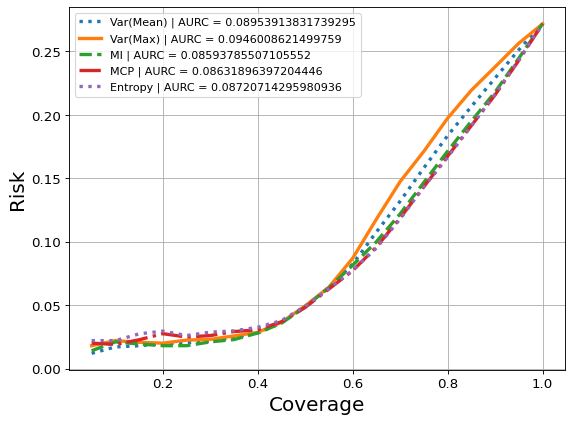

In [20]:
RC.plot_RC(aurc = True)
#plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

#### Deterministic inference

In [48]:
name = NAME + '_MCD_Det'
model_mcd = MonteCarloDropout(model,n_samples = N_SAMPLES, as_ensemble = False,name=name).to(dev)

In [50]:
RC = metrics.selective_metrics(model_mcd,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.fix_plot_scale(y_range=(0,rk_model))

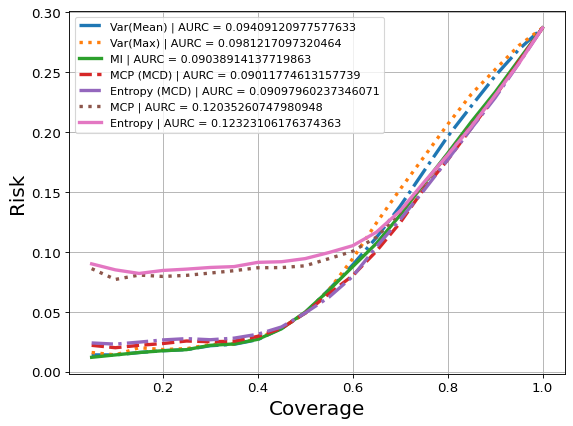

In [51]:
RC.plot_RC(aurc = True)

plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

### Monte Carlo Batch Normalization

In [ ]:
from uncertainty.MCBN import MonteCarloBatchNormalization as MCBN
N_SAMPLES = 10

#### MC Ensemble

In [ ]:
name = NAME + '_MCBN_Ens'
model_mcbn = MCBN(model,n_samples = N_SAMPLES, as_ensemble = True,name = name).to(dev)
print(f'MCD Ensemble Total Accuracy: {TE.model_acc(model_mcbn,data.test_dataloader)}')

In [ ]:
RC = metrics.selective_metrics(model_mcbn,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.fix_plot_scale(y_range=(0,rk_model))

In [ ]:
RC.plot_RC(aurc = True)
plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

#### Deterministic Inference

In [ ]:
name = NAME + '_MCBN_Ens'
model_mcbn = MCBN(model,n_samples = N_SAMPLES, as_ensemble = False,name = name).to(dev)
print(f'MCD Ensemble Total Accuracy: {TE.model_acc(model_mcbn,data.test_dataloader)}')

In [ ]:
RC = metrics.selective_metrics(model_mcbn,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.fix_plot_scale(y_range=(0,rk_model))

In [ ]:
RC.plot_RC(aurc = True)
plt.savefig(os.path.join(PATH_FIGS,name+'_RC'))

### Test-time augmentation

In [ ]:
from uncertainty.TestAugmentation import *

c_list = np.arange(0.05,1.05,0.05)
transforms = [F.hflip,
              Scale(1.04),
              Scale(1.1),
              Rotate(15),
              Rotate(-15),
              Multiply(0.8),
              Multiply(1.2),
              Add(0.1),
              Add(-0.1),
              FiveCrop(32,4)]

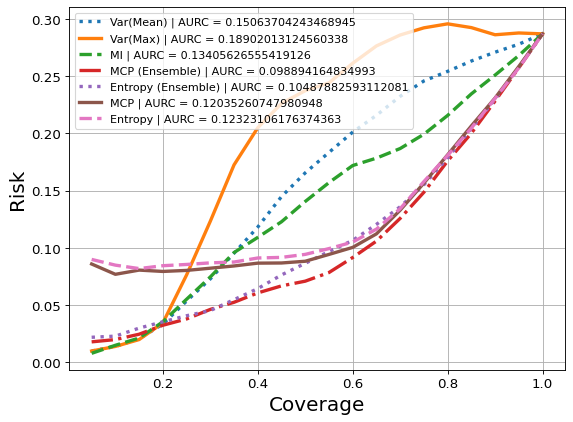

In [47]:
name = NAME + '_TTA'
TTA_model = TTA.TTA(model,as_ensemble = False, transforms = transforms,name = name).to(dev)

In [ ]:
RC = metrics.selective_metrics(TTA_model,data.test_dataloader, c_list = c_list)
RC.fix_plot_scale(y_range=(0,rk_model))

In [ ]:
RC.plot_RC(aurc = True)

### MIMO

In [ ]:
from uncertainty.mimo import MIMO_ensemble
N_ENS = 3
name = f'MIMO_{N_ENS}_' + NAME

mimo_path = os.path.join(weights_path,'MIMO')

In [35]:
mimo_model = MIMO_ensemble(model_class,num_classes = data.n_classes,ensemble_num = N_ENS, name = name, softmax = True)
mimo_model.model.load_state_dict(upload_weights(name, mimo_path))
mimo_model.eval()
TE.model_acc(mimo_model,data.test_dataloader)

72.16

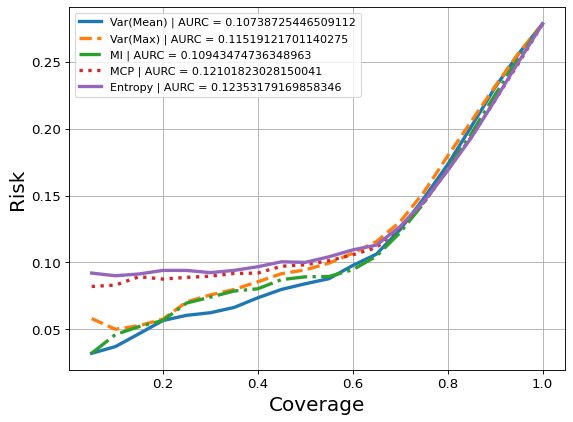

In [38]:
RC = metrics.selective_metrics(mimo_model,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.fix_plot_scale(y_range=(0,rk_model))

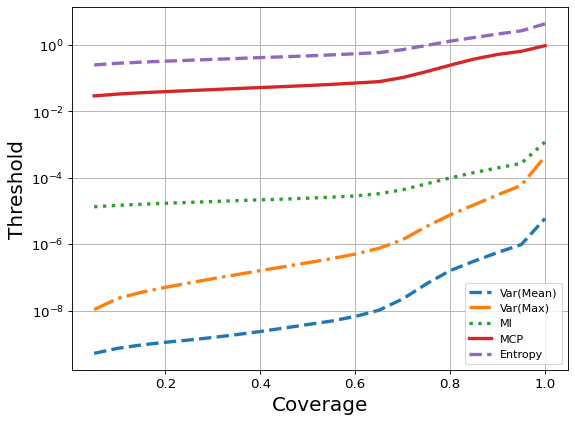

In [39]:
RC.plot_RC(aurc = True)